# Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pickle

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


## PCA:SVMS

In [4]:


def perform_PCA (DataFeatures, pca_n_features, train, data):
    ## Fit PCA to train data & rank components by AUC
    pca = PCA(n_components=len(DataFeatures))
    pca.fit(train[DataFeatures])

    ## Transform the desired dataset to get its principal components
    # Get ranked components by AUC from the train data
    principalComponents = pca.transform(train[DataFeatures])

    # Book will be a dictiorary with the AUC (values) of each component (keys)
    book = {}

    # Get values for AUC computation
    y_true = train['gen_label'].values
    weights = train["gen_xsec"].values

    # Renormalise weights
    weights[y_true == 1] = (weights[y_true == 1] / weights[y_true == 1].sum()) * weights.shape[0] / 2
    weights[y_true == 0] = (weights[y_true == 0] / weights[y_true == 0].sum()) * weights.shape[0] / 2

    for feature_idx in range(principalComponents.shape[1]):
        book[f"Component {feature_idx}"] = roc_auc_score(y_true=y_true, y_score=principalComponents[:, feature_idx], sample_weight=weights)

    # Give me the best features
    book = pd.DataFrame.from_dict(book, orient="index")
    book.columns = ["AUC"]
    book.sort_values(by="AUC", ascending=False, inplace=True)
    book.reset_index(inplace=True)
    book.rename(columns={"index": "Feature"}, inplace=True)

    ## Replace current data by its components ##
    # Get components for the current set we want
    principalComponents = pca.transform(data[DataFeatures])

    # Create a new dataframe with PCA data
    newdf = pd.DataFrame(principalComponents, columns=[f"Component {i}" for i in range(principalComponents.shape[1])])

    # Select the best components given their AUC performance in training data
    newdf = newdf[book["Feature"][0 : pca_n_features]]

    # Add the other relevant features
    newdf["gen_xsec"] = data["gen_xsec"].values
    newdf["gen_label"] = data["gen_label"].values
    newdf["gen_split"] = data["gen_split"].values

    # Finally, replace self.data with newdf
    data = newdf

    # Update DataFeatures
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
    
    return data, DataFeatures, book


In [5]:
def train_val_test(n_datapoints,n_features,method,type):
    data_frame_fcnc_pca = data_frame_fcnc.copy()
    data_frame_bkg_pca = data_frame_bkg.copy()

    # Drop the categorical features except label, weights and gen_split
    data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
    data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

    # Drop the features that are not in both dataframes
    for feature in data_frame_fcnc_pca.columns.values:
        if feature not in data_frame_bkg_pca.columns.values:
            data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

    for feature in data_frame_bkg_pca.columns.values:
        if feature not in data_frame_fcnc_pca.columns.values:
            data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
    # Join the dataframes
    data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

    # Substitute the labels "signal" and "bkg" by 1 and 0
    data = data.replace(['signal'], 1)
    data= data.replace(['bkg'], 0)

    # train set
    train = data.loc[data['gen_split'] == 'train']
    
    # which data will be used for fitting the PCA.
    # Everything except the weights, name and label
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))

    
    if method == "pca":
        # perform PCA on the train data
        data, DataFeatures, book = perform_PCA (DataFeatures,n_features, train, data)
        
    elif method == "sbs":
        Features = ['MissingET_MET', 'FatJet1_Tau1','FatJet1_Tau3','Jet2_PT','Jet1_PT']
        DataFeatures = Features[:n_features]
        
    if type == "ml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()
        
    elif type == "qml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (((data[DataFeatures] - data[DataFeatures].min()) / (data[DataFeatures].max() - data[DataFeatures].min())) * 2 - 1) * (np.pi)
  
    # divide the new data into train, test and validation sets
    train = data.loc[data['gen_split'] == 'train']
    test = data.loc[data['gen_split'] == 'test']
    val = data.loc[data['gen_split'] == 'val']

    # divide the train data into signal and background and get 500 samples of each
    train_sgn = train.loc[train['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    train_bkg = train.loc[train['gen_label'] == 0].sample(n=int(n_datapoints/2),random_state=42)
    x_train = pd.concat([train_sgn, train_bkg])
    x_train = x_train.sample(frac=1, random_state=42)

    # divide the validation data into signal and background and get 500 samples of each
    val_sgn = val.loc[val['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    val_bkg = val.loc[val['gen_label'] == 0].sample(n=int (n_datapoints/2), random_state=42)
    x_val = pd.concat([val_sgn, val_bkg])
    x_val = x_val.sample(frac=1, random_state=42)

    # divide the test data into signal and background and get 500 samples of each
    test_sgn = test.loc[test['gen_label'] == 1].sample(n=int(n_datapoints/2), random_state=42)
    test_bkg = test.loc[test['gen_label'] == 0].sample(n=int(n_datapoints/2), random_state=42)
    x_test = pd.concat([test_sgn, test_bkg])
    x_test = x_test.sample(frac=1, random_state=42)

    # get an array with the labels for each set
    y_train = x_train['gen_label'].values
    y_val = x_val['gen_label'].values
    y_test = x_test['gen_label'].values

    # get an array with the weights for each set
    w_train = x_train["gen_xsec"].values
    w_val = x_val["gen_xsec"].values
    w_test = x_test["gen_xsec"].values

    # get an array with the features for each set
    x_train = x_train[DataFeatures].values
    x_val = x_val[DataFeatures].values
    x_test = x_test[DataFeatures].values
    
    return x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test

#### SVMs : Grid search to find the best hyperparameters

In [6]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,3,'pca','ml')

In [7]:
param_grid = {
    'C': [0.0001, 0.1, 1, 5,  10, 50, 100,  150, 200, 500, 1000],
    'gamma': [0.0001,0.001,0.1,0.5,1,5,10, 'scale'],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,5]
}

# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test, sample_weight=w_test)
print("Test Score: ", test_score)

Best Hyperparameters:  {'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.5729999999999998
Test Score:  0.9973330210157807


In [8]:
'''
# Load data (deserialize)
with open('gridsearch_pca_svm_all.pickle', 'wb') as handle:
    grid_search = pickle.load(handle)
    
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)
'''

'\n# Load data (deserialize)\nwith open(\'gridsearch_pca_svm_all.pickle\', \'wb\') as handle:\n    grid_search = pickle.load(handle)\n    \ngrid_search.fit(x_train, y_train, sample_weight=w_train)\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n'

In [9]:
def train_svm (x_train,y_train, w_train, best_params):
    # Renormalize weights
    w_train[y_train == 1] = (w_train[y_train == 1] / w_train[y_train == 1].sum()) * w_train.shape[0] / 2
    w_train[y_train == 0] = (w_train[y_train == 0] / w_train[y_train == 0].sum()) * w_train.shape[0] / 2
    clf = svm.SVC(kernel=best_params['kernel'], probability=True, C=best_params['C'], gamma=best_params['gamma'], degree=best_params['degree'])   
    clf.fit(x_train, y_train,sample_weight=w_train)
    return clf

def val_svm (clf, x_val, y_val, w_val):
     # Renormalize weights
    w_val[y_val == 1] = (w_val[y_val == 1] / w_val[y_val == 1].sum()) * w_val.shape[0] / 2
    w_val[y_val == 0] = (w_val[y_val == 0] / w_val[y_val == 0].sum()) * w_val.shape[0] / 2
    y_pred = clf.predict(x_val)
    y_pred_prob = clf.predict_proba(x_val)[:,1]
    accuracy = accuracy_score(y_val, y_pred, sample_weight=w_val)
    auc = roc_auc_score(y_val, y_pred_prob, sample_weight=w_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob,sample_weight=w_val)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

def test_svm (clf, x_test, y_test, w_test):
    # Renormalize weights
    w_test[y_test == 1] = (w_test[y_test == 1] / w_test[y_test == 1].sum()) * w_test.shape[0] / 2
    w_test[y_test == 0] = (w_test[y_test == 0] / w_test[y_test == 0].sum()) * w_test.shape[0] / 2
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=w_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,sample_weight=w_test)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

In [10]:
pca_n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
accuracy_test_list_pca = []
accuracy_val_list_pca = []
auc_test_list_pca = []
auc_val_list_pca = []
for pca_n_features in pca_n_features_list:
    for n_datapoints in n_datapoints_list:
        print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints))
        x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,pca_n_features,'pca','ml')
        clf = train_svm(x_train,y_train, w_train, best_params)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = val_svm(clf, x_val, y_val, w_val)
        print('Accuracy Val: {}'.format(accuracy))
        print('AUC Val: {}'.format(auc))
        print('')
        auc_val_list_pca.append(auc)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = test_svm(clf, x_test, y_test, w_test)
        print('Accuracy Test: {}'.format(accuracy))
        print('AUC Test: {}'.format(auc))
        print('')
        auc_test_list_pca.append(auc)
        

Accuracy Val: 0.6908526505589101
AUC Val: 0.7644778442690647

Accuracy Test: 0.6918909729146747
AUC Test: 0.7236987981704259

Accuracy Val: 0.7161527677802038
AUC Val: 0.7824059787699758

Accuracy Test: 0.6770406613295737
AUC Test: 0.7485279030702972

Accuracy Val: 0.6834222362789738
AUC Val: 0.759452586156568

Accuracy Test: 0.7586234857693698
AUC Test: 0.817508250172826

Accuracy Val: 0.7076918397209032
AUC Val: 0.7452050065430169

Accuracy Test: 0.7607868722821483
AUC Test: 0.815988414736176

Accuracy Val: 0.7372768443232626
AUC Val: 0.7587437540882906

Accuracy Test: 0.7493050794955465
AUC Test: 0.7998734058877385

Accuracy Val: 0.6467026880785571
AUC Val: 0.6241908877067419

Accuracy Test: 0.6525032246284876
AUC Test: 0.7022625467897076

Accuracy Val: 0.6492122299504711
AUC Val: 0.6962686696974003

Accuracy Test: 0.5864252982320367
AUC Test: 0.6510754571111403

Accuracy Val: 0.7023710234522998
AUC Val: 0.7582388336296176

Accuracy Test: 0.7612121516538944
AUC Test: 0.7753936798233

### Without PCA:SVM - Grid search to find the best hyperparameters

In [11]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,3,'sbs','ml')

In [12]:
param_grid = {
    'C': [0.0001, 0.1, 1, 5,  10, 50, 100,  150, 200, 500, 1000],
    'gamma': [0.0001,0.001,0.1,0.5,1,5,10, 'scale'],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,5]
}
# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test, sample_weight=w_test)
print("Test Score: ", test_score)

Best Hyperparameters:  {'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.54
Test Score:  0.9934552282674692


In [13]:
'''
# Load data (deserialize)
with open('gridsearch_no_pca_svm_all.pickle', 'wb') as handle:
    grid_search = pickle.load(handle)
    
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)
'''

'\n# Load data (deserialize)\nwith open(\'gridsearch_no_pca_svm_all.pickle\', \'wb\') as handle:\n    grid_search = pickle.load(handle)\n    \ngrid_search.fit(x_train, y_train, sample_weight=w_train)\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n'

In [14]:
n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_no_pca = []
auc_val_list_no_pca = []
for n_features in n_features_list:
    for n_datapoints in n_datapoints_list:
        x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,n_features,'sbs','ml')
        clf = train_svm(x_train,y_train, w_train, best_params)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = val_svm(clf, x_val, y_val, w_val)
        print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints))
        print('Accuracy Val: {}'.format(accuracy))
        print('AUC Val: {}'.format(auc))
        print('')
        auc_val_list_no_pca.append(auc)
        accuracy, auc, fpr, tpr, thresholds, y_pred_prob = test_svm(clf, x_test, y_test, w_test)
        print('Accuracy Test: {}'.format(accuracy))
        print('AUC Test: {}'.format(auc))
        print('')
        auc_test_list_no_pca.append(auc)

N_components: 1 N_datapoints: 250
Accuracy Val: 0.6526760350460031
AUC Val: 0.6331012771493241

Accuracy Test: 0.7162780547520152
AUC Test: 0.744210254562954

N_components: 1 N_datapoints: 500
Accuracy Val: 0.6907067899552327
AUC Val: 0.7199015081854832

Accuracy Test: 0.689560408312074
AUC Test: 0.7388099614677863

N_components: 1 N_datapoints: 1000
Accuracy Val: 0.6692237595883855
AUC Val: 0.6892444954984996

Accuracy Test: 0.7394690795905606
AUC Test: 0.8110643076565

N_components: 1 N_datapoints: 2000
Accuracy Val: 0.6993429855673844
AUC Val: 0.7269079507757885

Accuracy Test: 0.6542477943487011
AUC Test: 0.7887534077446372

N_components: 1 N_datapoints: 4000
Accuracy Val: 0.728114910109055
AUC Val: 0.7867677897135338

Accuracy Test: 0.7343333121150336
AUC Test: 0.7772984100196796

N_components: 2 N_datapoints: 250
Accuracy Val: 0.6537063702738964
AUC Val: 0.6823485671688402

Accuracy Test: 0.6716341720135006
AUC Test: 0.7153934888847383

N_components: 2 N_datapoints: 500
Accuracy 

In [15]:
'''
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.plot([1, 2, 3], [1, 2, 3], label='Test')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()
'''

"\nfig, axes = plt.subplots(2, 3, figsize=(15, 6))\n\nfor i, ax in enumerate(axes.flat):\n    if i < 5:\n        ax.plot([1, 2, 3], [1, 2, 3], label='Test')\n        ax.legend()\n    else:\n        fig.delaxes(ax)\n\nfig.tight_layout()\nplt.show()\n"

### PLOT

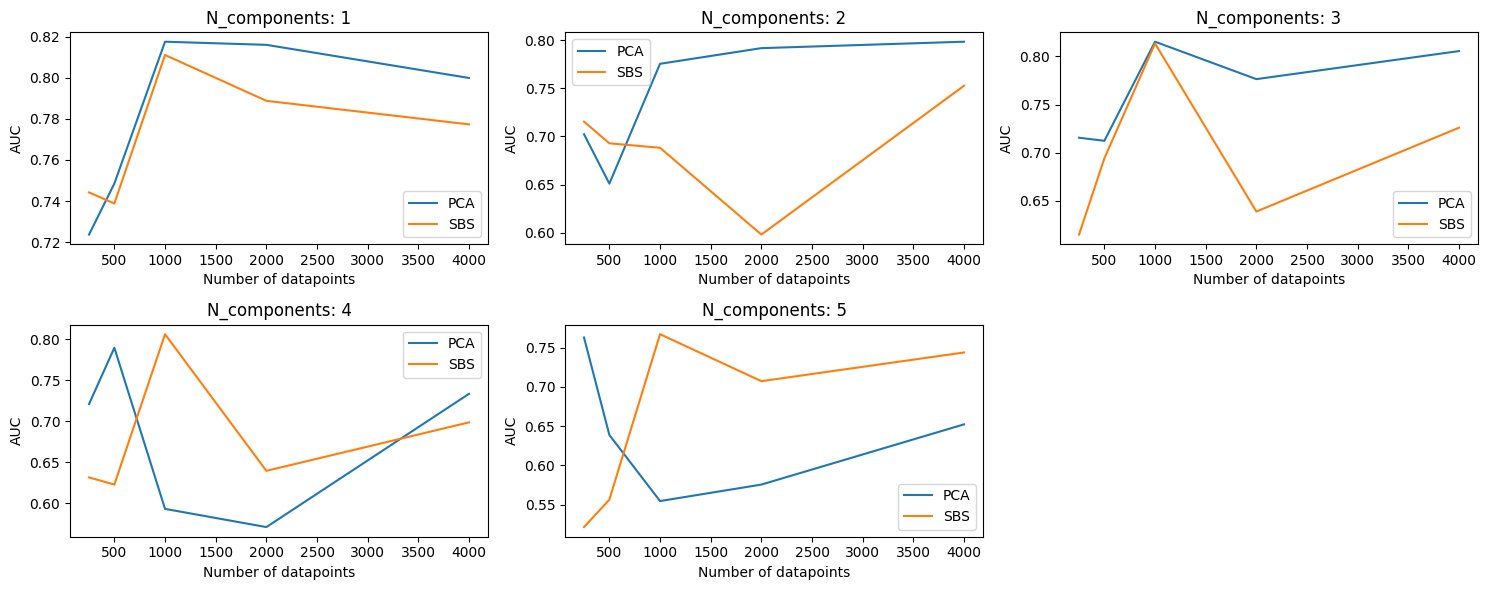

In [17]:
# Plot  the auc roc for the test set as a funtion of the number of datapoints for each number of components/features (i want to see 5 graphics seperatly with individual titles)
num_rows = 2
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i<5:
        ax.plot(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], label='PCA')
        ax.plot(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], label='SBS')
        ax.set_title('N_components: {}'.format(i+1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

## VQC

### PCA:VQC - Grid search to find the best hyperparameters

In [18]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,2,'pca','qml')

In [22]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train_vqc(n_features, n_layers, x_train, y_train,w_train,x_val,y_val,w_val, learning_rate, weights, max_epochs):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None
    epoch_number = 0

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 20 and epoch_number > 70:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights


def test_vqc(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return auc_score

In [27]:
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,lr, weights, 1000)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2989
Epoch: 1, Loss: 60.2973
Epoch: 2, Loss: 60.2949
Epoch: 3, Loss: 60.2919
Epoch: 4, Loss: 60.2881
Epoch: 4, Validation Loss: 121.1907, AUC Score: 0.4767
Best Score: 0.4767


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2862
Epoch: 1, Loss: 60.2538
Epoch: 2, Loss: 60.2031
Epoch: 3, Loss: 60.1338
Epoch: 4, Loss: 60.0455
Epoch: 4, Validation Loss: 120.4497, AUC Score: 0.4880
Best Score: 0.4880


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2542
Epoch: 1, Loss: 60.1334
Epoch: 2, Loss: 59.9417
Epoch: 3, Loss: 59.6772
Epoch: 4, Loss: 59.3389
Epoch: 4, Validation Loss: 118.3100, AUC Score: 0.5157
Best Score: 0.5157


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2966
Epoch: 1, Loss: 59.2728
Epoch: 2, Loss: 57.1562
Epoch: 3, Loss: 53.7087
Epoch: 4, Loss: 49.2337
Epoch: 4, Validation Loss: 87.8126, AUC Score: 0.6299
Best Score: 0.6299


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2866
Epoch: 1, Loss: 55.8988
Epoch: 2, Loss: 48.6560
Epoch: 3, Loss: 38.8538
Epoch: 4, Loss: 31.2102
Epoch: 4, Validation Loss: 59.0546, AUC Score: 0.6689
Best Score: 0.6689


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2903
Epoch: 1, Loss: 29.6824
Epoch: 2, Loss: 50.2150
Epoch: 3, Loss: 39.2646
Epoch: 4, Loss: 36.2445
Epoch: 4, Validation Loss: 59.3163, AUC Score: 0.6689
Best Score: 0.6689


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2920
Epoch: 1, Loss: 38.0637
Epoch: 2, Loss: 43.1590
Epoch: 3, Loss: 38.6796
Epoch: 4, Loss: 29.8880
Epoch: 4, Validation Loss: 75.8262, AUC Score: 0.6746
Best Score: 0.6746


In [ ]:
'''
# load the best score, best weights and best learning rate
with open('best_score_pca_vqc_all.pickle', 'wb') as handle:
    best_score = pickle.load(handle)

with open('best_weights_pca_vqc_all.pickle', 'wb') as handle:
    best_weights = pickle.load(handle)
 
with open('best_lr_pca_vqca_all.pickle', 'wb') as handle:
    best_lr=pickle.load(best_lr)
    
print (best_score)
print (best_weights)
print (best_lr)

'''

In [33]:
pca_n_features_list = [1,2,3,4,5]
n_layers_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_pca_vqc = []
auc_val_list_pca_vqc = []
for pca_n_features in pca_n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, pca_n_features, 3, requires_grad=True)
            x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,pca_n_features,'pca','qml')             
            best_score, best_weights = train_vqc(pca_n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,best_lr, weights, 1000)
            auc_score_val = test_vqc(pca_n_features, n_layers,x_val,y_val,w_val, best_weights)
            print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_score_val))
            print('')
            auc_score_test = test_vqc(pca_n_features, n_layers,x_test,y_test,w_test, best_weights)
            print('AUC Test: {}'.format(auc_score_test))
            print('')
            auc_test_list_pca_vqc.append(auc_score_test)
            auc_val_list_pca_vqc.append(auc_score_val)

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.3002
Epoch: 1, Loss: 37.5130
Epoch: 2, Loss: 28.2013
Epoch: 3, Loss: 35.1893
Epoch: 4, Loss: 31.5029
Epoch: 4, Validation Loss: 56.1717, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 1
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2484
Epoch: 1, Loss: 75.3928
Epoch: 2, Loss: 57.4661
Epoch: 3, Loss: 71.1044
Epoch: 4, Loss: 62.7958
Epoch: 4, Validation Loss: 108.3261, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 1
AUC Val: 0.7684924467955978

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2905
Epoch: 1, Loss: 39.2091
Epoch: 2, Loss: 45.0672
Epoch: 3, Loss: 41.5240
Epoch: 4, Loss: 36.4795
Epoch: 4, Validation Loss: 59.2630, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 2
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2483
Epoch: 1, Loss: 87.5461
Epoch: 2, Loss: 106.4048
Epoch: 3, Loss: 79.8514
Epoch: 4, Loss: 59.0857
Epoch: 4, Validation Loss: 127.9701, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 2
AUC Val: 0.7684928571147385

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 31.5831
Epoch: 1, Loss: 34.5165
Epoch: 2, Loss: 32.3685
Epoch: 3, Loss: 30.4440
Epoch: 4, Loss: 29.2894
Epoch: 4, Validation Loss: 66.5157, AUC Score: 0.5884
Best Score: 0.5884
N_components: 2 N_datapoints: 250 N_layers: 1
AUC Val: 0.6118115094587675

AUC Test: 0.7598035136888505



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 66.1254
Epoch: 1, Loss: 68.3691
Epoch: 2, Loss: 64.0351
Epoch: 3, Loss: 69.9384
Epoch: 4, Loss: 70.4028
Epoch: 4, Validation Loss: 131.4090, AUC Score: 0.3941
Best Score: 0.3941
N_components: 2 N_datapoints: 500 N_layers: 1
AUC Val: 0.44495377677680636

AUC Test: 0.38032308489855077



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.3416
Epoch: 1, Loss: 35.7286
Epoch: 2, Loss: 34.2660
Epoch: 3, Loss: 36.9523
Epoch: 4, Loss: 29.5333
Epoch: 4, Validation Loss: 66.7736, AUC Score: 0.5783
Best Score: 0.5783
N_components: 2 N_datapoints: 250 N_layers: 2
AUC Val: 0.598997673980441

AUC Test: 0.7423187880221267



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.0877
Epoch: 1, Loss: 89.1557
Epoch: 2, Loss: 81.3312
Epoch: 3, Loss: 61.9331
Epoch: 4, Loss: 57.5242
Epoch: 4, Validation Loss: 180.3444, AUC Score: 0.7795
Best Score: 0.7795
N_components: 2 N_datapoints: 500 N_layers: 2
AUC Val: 0.7722875090338801

AUC Test: 0.7474295428265585



In [ ]:
'''
# load the best score, best weights and best learning rate
with open('auc_test_list_pca_vqc.pickle', 'wb') as handle:
    auc_test_list_pca_vqc= load(handle)

with open('auc_val_list_pca_vqc.pickle', 'wb') as handle:
    auc_val_list_pca_vqc.pickle= load(handle)
 
print (auc_test_list_pca_vqc)
print (auc_val_list_pca_vqc)

'''

### Without PCA:VQC -Grid search to find the best hyperparameters

In [34]:
# get the train, test and validation sets
x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(1000,2,'sbs','qml')

In [35]:
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,lr, weights, 1000)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 283.4613
Epoch: 1, Loss: 283.4382
Epoch: 2, Loss: 283.4106
Epoch: 3, Loss: 283.3786
Epoch: 4, Loss: 283.3419
Epoch: 4, Validation Loss: 456.2181, AUC Score: 0.2827
Best Score: 0.2827


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 283.4558
Epoch: 1, Loss: 282.9794
Epoch: 2, Loss: 282.1552
Epoch: 3, Loss: 280.9535
Epoch: 4, Loss: 279.3664
Epoch: 4, Validation Loss: 446.7822, AUC Score: 0.2848
Best Score: 0.2848


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 283.3866
Epoch: 1, Loss: 260.6691
Epoch: 2, Loss: 229.6468
Epoch: 3, Loss: 197.6463
Epoch: 4, Loss: 174.1941
Epoch: 4, Validation Loss: 270.7761, AUC Score: 0.4077
Best Score: 0.4077


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 283.4266
Epoch: 1, Loss: 208.2352
Epoch: 2, Loss: 255.3118
Epoch: 3, Loss: 151.5949
Epoch: 4, Loss: 141.5378
Epoch: 4, Validation Loss: 256.7282, AUC Score: 0.7012
Best Score: 0.7012


In [ ]:
'''
# load the best score, best weights and best learning rate
with open('best_score_no_pca_vqc_all.pickle', 'wb') as handle:
    best_score = pickle.load(handle)

with open('best_weights_no_pca_vqc_all.pickle', 'wb') as handle:
    best_weights = pickle.load(handle)
 
with open('best_lr_no_pca_vqca_all.pickle', 'wb') as handle:
    best_lr=pickle.load(handle)
    
print (best_score)
print (best_weights)
print (best_lr)

'''

In [36]:
n_features_list = [1,2,3,4,5]
n_layers_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_no_pca_vqc = []
auc_val_list_no_pca_vqc = []
for n_features in n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)
            x_train, y_train, w_train, x_val, y_val, w_val, x_test, y_test, w_test = train_val_test(n_datapoints,n_features,'pca','qml')             
            best_score, best_weights = train_vqc(n_features, n_layers,x_train,y_train,w_train, x_val,y_val,w_train,best_lr, weights, 1000)
            auc_score_val = test_vqc(n_features, n_layers,x_val,y_val,w_val, best_weights)
            print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_score_val))
            print('')
            auc_score_test = test_vqc(n_features, n_layers,x_test,y_test,w_test, best_weights)
            print('AUC Test: {}'.format(auc_score_test))
            print('')
            auc_test_list_no_pca_vqc.append(auc_score_test)
            auc_val_list_no_pca_vqc.append(auc_score_val)

Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2936
Epoch: 1, Loss: 37.1124
Epoch: 2, Loss: 28.5297
Epoch: 3, Loss: 35.0341
Epoch: 4, Loss: 31.0776
Epoch: 4, Validation Loss: 56.0721, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 1
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2466
Epoch: 1, Loss: 75.0641
Epoch: 2, Loss: 57.7179
Epoch: 3, Loss: 71.0478
Epoch: 4, Loss: 62.4535
Epoch: 4, Validation Loss: 108.3538, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 1
AUC Val: 0.7684924391619996

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2939
Epoch: 1, Loss: 38.9916
Epoch: 2, Loss: 45.6976
Epoch: 3, Loss: 40.6141
Epoch: 4, Loss: 35.6382
Epoch: 4, Validation Loss: 59.9341, AUC Score: 0.6689
Best Score: 0.6689
N_components: 1 N_datapoints: 250 N_layers: 2
AUC Val: 0.7419797308342647

AUC Test: 0.7247790722589644



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.2401
Epoch: 1, Loss: 79.0133
Epoch: 2, Loss: 95.1160
Epoch: 3, Loss: 80.0883
Epoch: 4, Loss: 69.7117
Epoch: 4, Validation Loss: 119.7701, AUC Score: 0.7449
Best Score: 0.7449
N_components: 1 N_datapoints: 500 N_layers: 2
AUC Val: 0.7684924467955978

AUC Test: 0.7430256472954327



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 31.5839
Epoch: 1, Loss: 34.4750
Epoch: 2, Loss: 32.1443
Epoch: 3, Loss: 30.2892
Epoch: 4, Loss: 29.6780
Epoch: 4, Validation Loss: 64.7794, AUC Score: 0.5914
Best Score: 0.5914
N_components: 2 N_datapoints: 250 N_layers: 1
AUC Val: 0.6115227960888513

AUC Test: 0.756636860487863



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 66.1122
Epoch: 1, Loss: 71.7639
Epoch: 2, Loss: 66.1742
Epoch: 3, Loss: 63.1280
Epoch: 4, Loss: 61.0031
Epoch: 4, Validation Loss: 135.2869, AUC Score: 0.6508
Best Score: 0.6508
N_components: 2 N_datapoints: 500 N_layers: 1
AUC Val: 0.6023677001388952

AUC Test: 0.6619445881469057



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 60.2767
Epoch: 1, Loss: 34.8338
Epoch: 2, Loss: 35.2097
Epoch: 3, Loss: 31.8174
Epoch: 4, Loss: 34.6256
Epoch: 4, Validation Loss: 73.3227, AUC Score: 0.6247
Best Score: 0.6247
N_components: 2 N_datapoints: 250 N_layers: 2
AUC Val: 0.7025687666835956

AUC Test: 0.593819005742078



Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 124.4404
Epoch: 1, Loss: 89.4798
Epoch: 2, Loss: 113.8939
Epoch: 3, Loss: 89.8561
Epoch: 4, Loss: 84.6255
Epoch: 4, Validation Loss: 158.8493, AUC Score: 0.5247
Best Score: 0.5247
N_components: 2 N_datapoints: 500 N_layers: 2
AUC Val: 0.5560830611733358

AUC Test: 0.4712391103656638



In [ ]:
'''
# load the best score, best weights and best learning rate
with open('auc_test_list_no_pca_vqc.pickle', 'wb') as handle:
    auc_test_list_pca_vqc = pickle.load(handle)

with open('auc_val_list_no_pca_vqc.pickle ', 'wb') as handle:
    auc_val_list_pca_vqc = pickle.load(handle)
 
print (auc_test_list_no_pca_vqc)
print (auc_val_list_no_pca_vqc)

'''

### PLOT

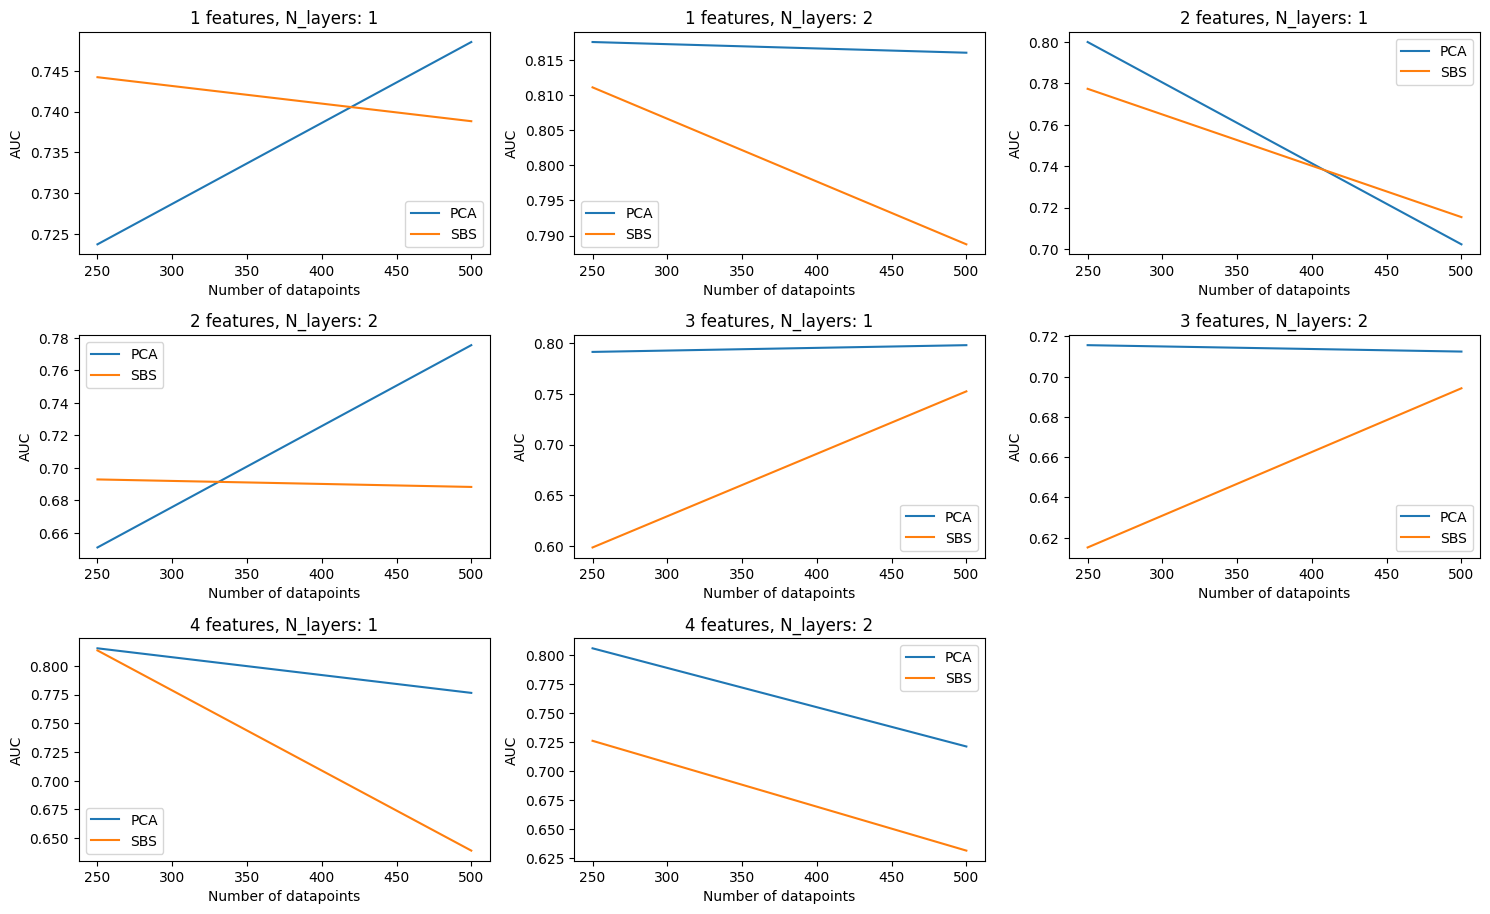

In [39]:
num_rows = 9
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i < 8:
        ax.plot(n_datapoints_list, auc_test_list_pca[i * 2:(i + 1) * 2], label='PCA')
        ax.plot(n_datapoints_list, auc_test_list_no_pca[i * 2:(i + 1) * 2], label='SBS')
        ax.set_title('{} features, N_layers: {}'.format((i // 2) + 1, i % 2 + 1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()